# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy

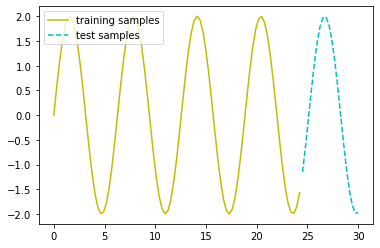

In [2]:
x = np.linspace(0, 30, 105)
y = 2 * np.sin(x)

l1, = plt.plot(x[:85], y[:85], 'y', label = 'training samples')
l2, = plt.plot(x[85:], y[85:105], 'c--', label = 'test samples')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

<a id='Session2'></a>
## Real-world training data may be noisier

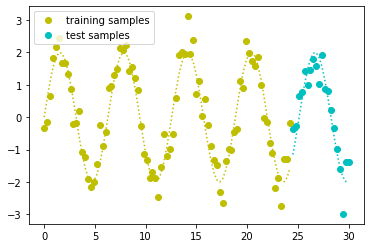

In [3]:
train_y = y.copy()

noise_factor = 0.5
train_y += np.random.randn(105) * noise_factor

l1, = plt.plot(x[:85], train_y[:85], 'yo', label = 'training samples')
plt.plot(x[:85], y[:85], 'y:')
l2, = plt.plot(x[85:], train_y[85:], 'co', label = 'test samples')
plt.plot(x[85:], y[85:], 'c:')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## Create function for generating training samples

In [4]:
input_seq_len = 15
output_seq_len = 20

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x):
    return true_signal(x) + noise_func(x)

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x) for x in input_seq_x]
    output_seq_y = [generate_y_values(x) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


In [5]:
input_seq,output_seq = generate_train_samples()
input_seq.shape,output_seq.shape

((10, 15), (10, 20))

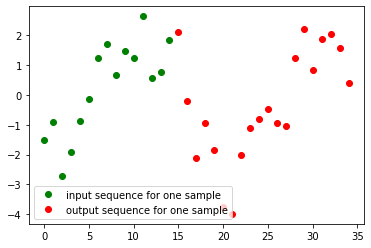

In [6]:
l1, = plt.plot(range(15), input_seq[1], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[1], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

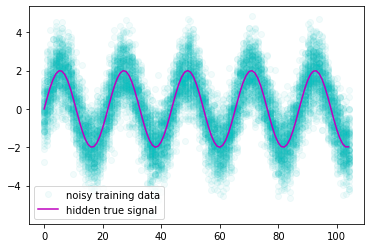

In [7]:
results = []
for i in range(100):
    temp = generate_y_values(x)
    results.append(temp)
results = np.array(results)

for i in range(100):
    l1, = plt.plot(results[i].reshape(105, -1), 'co', lw = 0.1, alpha = 0.05, label = 'noisy training data')

l2, = plt.plot(true_signal(x), 'm', label = 'hidden true signal')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [8]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

/home/harrison/.conda/envs/tpot/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## Training process

In [9]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
59.528183
55.51746
46.17335
32.17879
32.56941
34.400723
31.063011
25.967466
27.998484
25.405388
24.832293
25.26094
22.857666
22.660915
23.513926
23.832031
22.303904
20.018719
24.84863
22.872967
28.123621
21.887127
21.586136
23.80529
23.55767
24.12823
24.150614
22.455423
24.661545
20.776468
24.894491
21.995298
29.22139
23.323193
23.153502
25.493353
29.896713
24.905273
21.44252
22.641298
24.21344
21.756714
19.578978
21.13085
22.768047
24.196018
22.840977
23.2526
21.365114
21.293114
23.9322
25.824087
22.59735
20.979393
20.60979
23.563133
22.177118
26.

## Inference

In [12]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


## Plot the last 20 predictions

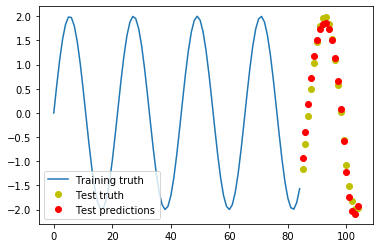

In [13]:
l1, = plt.plot(range(85), true_signal(train_data_x[:85]), label = 'Training truth')
l2, = plt.plot(range(85, 105), y[85:], 'yo', label = 'Test truth')
l3, = plt.plot(range(85, 105), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

<a id='session2'></a>
# Multivariate time series: 


### Input sequences

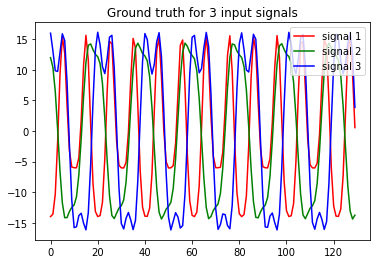

In [14]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2*x1 + 6*x2 - 6*x1
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

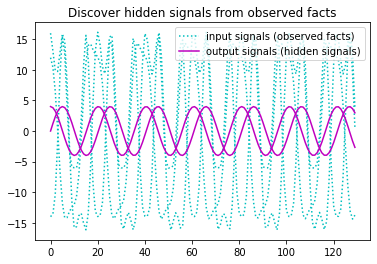

In [15]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

plt.legend(handles = [l1, l4], loc = 'upper right')

plt.show()

## Create function that generates training samples

In [16]:
input_seq_len = 15
output_seq_len = 20
x = np.linspace(0, 40, 130)
train_data_x = x[:110]

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = 1.6*x1**4 - 2*x2 - 10
    y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
    y3 = 2*x1**3 + 2*x2**3 - x1*x2
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

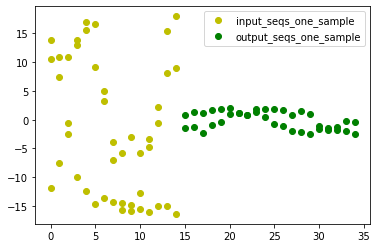

In [17]:
input_seq, output_seq = generate_train_samples(batch_size=100)

i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show()



## Build the model

In [18]:
from build_model_multi_variate import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Train the model

In [19]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
51.25709
29.823715
28.23832
20.396708
27.745672
12.970863
11.767118
10.334205
10.863099
8.366758
7.1930056
8.0018015
7.058907
6.8640003
6.6774616
6.3713994
6.545874
6.7442946
6.3051515
6.2786913
6.391788
6.1298237
6.395901
5.8360896
5.663659
5.9623475
5.551788
5.7840524
6.1424794
5.3504457
5.47271
5.5071645
6.05539
6.094325
6.2914233
6.0391154
5.2062182
5.651738
5.866898
6.419837
6.420607
6.7735133
5.6976357
5.149081
5.9693065
5.701406
6.529338
5.7087936
5.5680513
6.142978
6.402447
5.852374
6.0729823
5.929995
6.3523498
5.679609
5.6701894
6.0667076
6.060635
6.0173597
5.806013
5.7193646
5.337734
5.612264
5.778445
6.03843
5.976484
6.0260105
6.385202
5.554156
5.891556
5.611974
5.954149
6.5287137
5.892482
5.506502
5.447785
6.0899115
5.7415247
5.610008
5.9348617
6.175253
5.981611
5.705073
5.501335
6.1501355
5.975093
6.048831
6.429309
5.632872
5.845916
6.1497264
6.2824974
5.507683
5.602396
5.4492755
5.871292
5.930922
5.5234284
5.4249125
Checkpoint saved at:  ./multivariate_t

## Inference

In [20]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    

INFO:tensorflow:Restoring parameters from ./multivariate_ts_model0


## Visualize predictions over true signals 

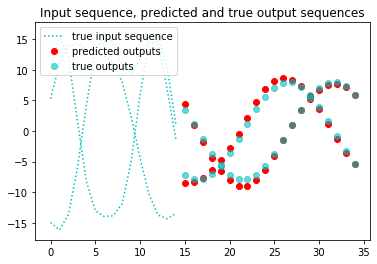

In [21]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Input sequence, predicted and true output sequences")
i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), 4 * final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), 4 * np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', alpha = 0.6, label = 'true outputs')
plt.legend(handles = [i1, p1, t1], loc = 'upper left')
plt.show()


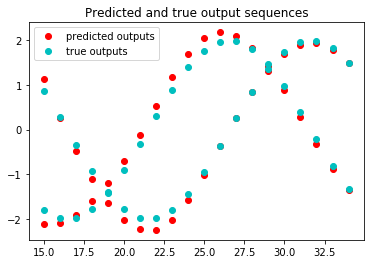

In [22]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', label = 'true outputs')
plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()

<a id='session3'></a>
# Extreme events / outliers

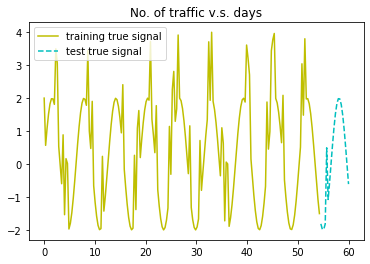

In [23]:
x = np.linspace(0, 60, 210)
y = 2 * np.sin(x)
num_events_train = 40
num_events_test = 1
extreme_factor = 2
np.random.seed(10)
train_events_x = np.random.choice(range(190), num_events_train)
test_events_x = np.random.choice(range(190, 210), num_events_test)
y[train_events_x] += extreme_factor
y[test_events_x] += extreme_factor

plt.title('No. of traffic v.s. days')

l1, = plt.plot(x[:190], y[:190], 'y', label = 'training true signal')
l2, = plt.plot(x[190:], y[190:], 'c--', label = 'test true signal')

plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

In [24]:
input_seq_len = 15
output_seq_len = 20
extreme_factor = 2 # additional units of traffic increase if extreme / outlier

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

np.random.seed(10)
num_events_train = 40 # total number of extreme events in training data
train_events_bool = np.zeros(190)
train_events_x = np.random.choice(range(190), num_events_train)
train_events_bool[train_events_x] = 1

num_events_test = 1 # total number of extreme events in test data 
test_events_bool = np.zeros(20)
test_events_x = np.random.choice(range(20), num_events_test)
test_events_bool[test_events_x] = 1.
                    
def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, event_bool):
    return true_signal(x) + noise_func(x) + extreme_factor * event_bool

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len, train_events_bool = train_events_bool):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    input_seq_event_bool = [train_events_bool[i:(i+input_seq_len)] for i in start_x_idx]
    
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    output_seq_event_bool = [train_events_bool[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(input_seq_x, input_seq_event_bool)]
    output_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(output_seq_x, output_seq_event_bool)]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y), np.array(input_seq_event_bool), np.array(output_seq_event_bool)

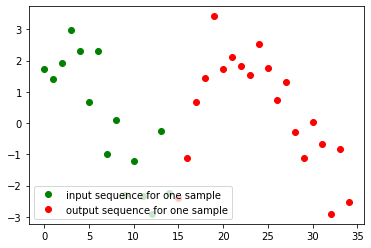

In [25]:
input_seq, output_seq, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=10)
l1, = plt.plot(range(15), input_seq[0], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[0], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## 1) Using the basic univariate model

In [26]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 


In [27]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

75.86373
57.021725
53.23292
48.06521
48.917328
38.555363
36.788776
39.361404
41.372154
33.413437
35.799915
36.274048
35.126865
39.44217
37.574135
40.733917
42.524727
40.954666
36.274323
42.2512
37.890488
33.995575
34.61585
36.283417
32.17021
34.202866
37.896606
29.84435
35.92161
42.13878
31.860594
32.572456
33.341564
36.474678
33.55105
34.30274
36.013332
37.041687
33.150677
37.176422
35.038105
33.94416
29.867237
31.982176
32.388855
34.753437
32.078205
37.573666
30.40154
35.59683
32.5129
35.51279
36.58716
34.136757
33.646538
32.843613
41.037857
36.260605
34.58884
34.879215
38.094883
42.1403
37.768806
31.44255
33.509068
33.67376
34.197517
37.777805
33.50089
37.746086
36.309578
36.992188
36.24139
35.408745
35.555946
40.42666
34.45763
37.32128
31.237085
34.57941
36.235455
34.9073
34.372826
33.756718
32.630943
31.84667
35.455654
34.929207
35.939293
32.55176
34.57592
32.943596
34.668087
35.382843
37.75525
33.518913
34.885563
31.890474
35.172497
36.000603
33.544853
31.542244
32.772156
33.6964

## Inference

In [28]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


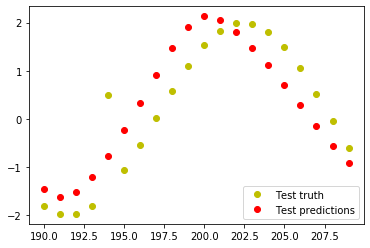

In [29]:
#l1, = plt.plot(range(190), true_signal(train_data_x[:190]), label = 'Training truth')
l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

## 2) Using seq2seq with extreme events input to decoder

In [30]:
from build_model_with_outliers import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

In [31]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, batch_in_event_bool, batch_out_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        #feed_dict.update({rnn_model['input_seq_extremes_bool'][t]: batch_in_event_bool[:,t].reshape(-1,1) for t in range(input_seq_len)})
        feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: batch_out_event_bool[:,t].reshape(-1,1) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
        
print("Checkpoint saved at: ", save_path)

76.16621
61.004856
60.69617
40.600346
47.60627
50.161488
44.59231
37.271652
43.484005
36.317772
37.823135
36.42796
34.83902
42.403004
37.78292
36.606388
40.385376
32.94139
33.57929
35.84001
32.073616
32.95085
35.085434
35.94612
33.257477
29.83295
31.646029
31.118176
33.633324
32.743214
31.635227
32.66877
33.5315
35.503506
29.0089
30.277208
35.3528
27.90542
30.51952
27.341587
28.349548
24.645805
31.387001
31.274317
25.208015
26.427238
21.215057
26.700897
24.267218
24.289488
26.179377
23.570244
25.638018
22.347654
25.243334
20.269865
24.259972
25.253374
24.105349
25.282177
23.76955
21.11379
27.530231
26.091782
22.240934
20.739077
21.620722
24.713615
29.631893
24.969296
23.932539
24.961195
24.422884
25.019781
26.253315
28.523964
30.858372
25.031609
25.150824
24.82125
24.805962
29.14399
23.346724
24.046507
23.486021
24.24678
28.384188
31.884647
27.686722
23.894367
29.517147
24.142332
31.17753
23.592857
21.109228
25.293175
21.788383
26.062449
21.290964
25.013096
22.525816
22.52169
22.709356

## Inference

In [32]:
test_seq_input = true_signal(train_data_x[-15:])
test_events_bool_input = train_events_bool[-15:]
test_events_bool_output = test_events_bool.copy()

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, 1]) for t in range(output_seq_len)})
    feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: test_events_bool_output[t].reshape(1,1) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    

INFO:tensorflow:Restoring parameters from ./univariate_ts_model_eventsBool


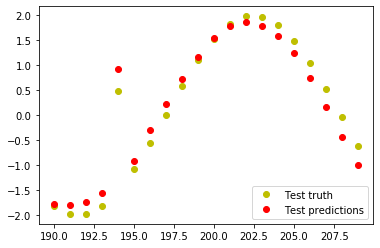

In [33]:
final_preds  = np.array(final_preds).reshape(-1)

l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

<a id='session4'></a>
# Real-world case - Beijing PM2.5 Data Set

This data set can be downloaded from UCI website - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The remaining session will use this dataset as an example to demonstrate on how to apply seq2seq model to solve a real world problem



## Data exploration

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


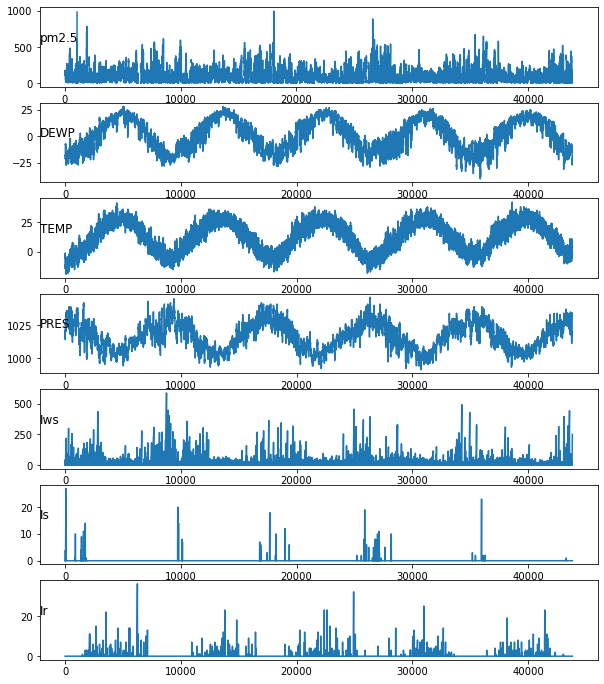

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
print(df.head())

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

## Preprocessing - there are many other ways

In [36]:
## Fill NA with 0 
#print(df.isnull().sum())
df.fillna(0, inplace = True)

## One-hot encode 'cbwd'
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling - you may also keep 'hour', 'day' or 'month' and to see if that will improve your accuracy
X_train = df_train.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
X_test = df_test.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
y_train = df_train['pm2.5'].values.copy().reshape(-1, 1)
y_test = df_test['pm2.5'].values.copy().reshape(-1, 1)

## z-score transform x - not including those one-how columns!
for i in range(X_train.shape[1]-4):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [37]:
input_seq_len = 30
output_seq_len = 5

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [38]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 30, 11) (10, 5, 1)


In [39]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(709, 30, 11) (709, 5, 1)


## Building the model - same multi-variate graph

In [40]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model 

In [41]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
10.86869
21.099566
9.974373
8.209596
4.2441163
2.1845467
1.4432894
3.6377292
1.8994806
2.2321076
0.9396795
1.8961914
1.3328248
1.0890493
1.0795813
2.1973822
0.8317751
0.70258933
1.9453518
1.2134647
1.210222
0.55166984
0.9621196
0.69923425
0.37979835
1.190728
0.8490929
0.51385516
0.44108623
0.65923285
0.6660099
0.99363804
0.75807476
0.40041524
3.05444
1.1626285
0.6215721
0.24210082
0.44296694
1.0168439
0.2722708
0.33636013
0.64165086
0.2764565
0.50678235
0.6074632
1.5936354
0.53019696
2.364786
0.21171178
0.3641614
2.2560408
0.457905
0.3662633
0.47457024
0.5013183
0.49311754
0.37523398
0.5378726
0.3043146
0.305678
0.34203407
1.3644911
0.488314
0.2830195
0.36690482
0.53027594
1.0825258
0.5998393
0.36718816
0.2676019
0.4969615
0.7497381
0.43611842
0.59100294
0.32319742
0.22418034
0.83111256
0.3121959
0.62597567
0.76968575
0.37291926
0.6130133
0.5558757
0.69446665
0.5203378
0.34740856
0.3185231
0.2566012
0.26819348
0.6513068
0.5262606
0.6764822
0.8155476
0.32349455
1.11954

## Inference on test 
Notice the batch prediction which is different to previous

In [42]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
Test mse is:  0.3824993936720338


In [43]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

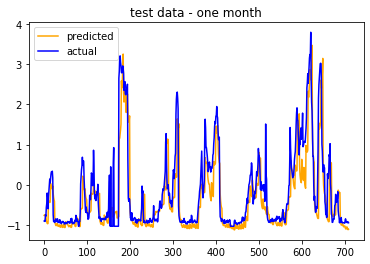

In [44]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()